In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

In [2]:
data = pd.read_csv('Sunspots.csv')
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [3]:
len(data['Date'])

3235

In [4]:
time_step = []
sunspots = []
with open('Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)

In [5]:
def plot_series(time, series, sign = '-', end = None, start = 0):
    plt.plot(time[start:end], series[start:end], sign)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

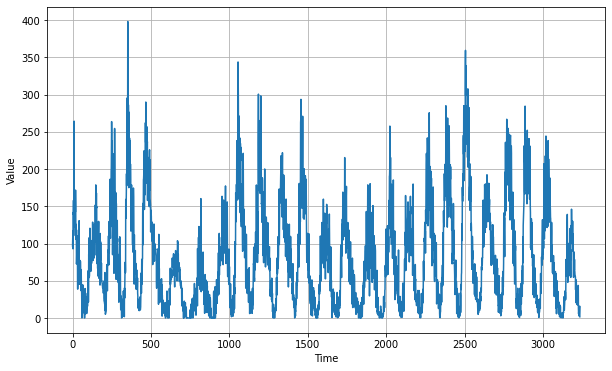

In [6]:
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[: split_time]
x_train = series[: split_time]

time_valid = time[split_time: ]
x_valid = series[split_time: ]

In [8]:
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-1], window[-1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
batch_size = 256
shuffle_buffer = 1000

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32,
                           kernel_size = 5,
                           padding = 'causal',
                           strides = 1,
                           input_shape = [None, 1],
                           activation = 'relu'),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9),
              metrics = ['mae'])

In [11]:
training = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

history = model.fit(training,
                    epochs = 100,
                    callbacks = [lr_schedule])

Epoch 1/100
12/12 [==============================] - 6s 236ms/step - loss: 73.7885 - mae: 74.2841 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 2s 154ms/step - loss: 73.6945 - mae: 74.1901 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 2s 154ms/step - loss: 73.5589 - mae: 74.0546 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 2s 155ms/step - loss: 73.3996 - mae: 73.8952 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 2s 155ms/step - loss: 73.2216 - mae: 73.7173 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 2s 155ms/step - loss: 73.0263 - mae: 73.5220 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 2s 155ms/step - loss: 72.8106 - mae: 73.3064 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 2s 157ms/step - loss: 72.5777 - mae: 73.0735 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 2s 155ms/step - loss: 72.32

12/12 [==============================] - 2s 154ms/step - loss: 45.6643 - mae: 46.1616 - lr: 3.1623e-05
Epoch 72/100
12/12 [==============================] - 2s 152ms/step - loss: 45.5433 - mae: 46.0405 - lr: 3.5481e-05
Epoch 73/100
12/12 [==============================] - 2s 151ms/step - loss: 44.4319 - mae: 44.9292 - lr: 3.9811e-05
Epoch 74/100
12/12 [==============================] - 2s 151ms/step - loss: 44.1458 - mae: 44.6431 - lr: 4.4668e-05
Epoch 75/100
12/12 [==============================] - 2s 152ms/step - loss: 43.5683 - mae: 44.0655 - lr: 5.0119e-05
Epoch 76/100
12/12 [==============================] - 2s 151ms/step - loss: 43.3631 - mae: 43.8603 - lr: 5.6234e-05
Epoch 77/100
12/12 [==============================] - 2s 154ms/step - loss: 44.1190 - mae: 44.6163 - lr: 6.3096e-05
Epoch 78/100
12/12 [==============================] - 2s 152ms/step - loss: 44.9334 - mae: 45.4308 - lr: 7.0795e-05
Epoch 79/100
12/12 [==============================] - 2s 151ms/step - loss: 43.5616 -

(1e-08, 0.0001, 0.0, 60.0)

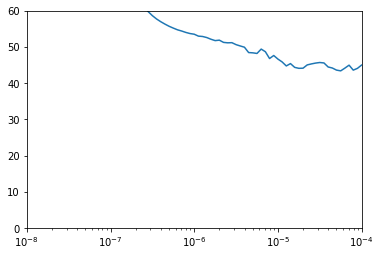

In [12]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()

training = window_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer = shuffle_buffer)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 60,
                           kernel_size = 5,
                           padding = 'causal',
                           strides = 1,
                           input_shape = [None, 1],
                           activation = 'relu'),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(training, 
                    epochs = 500)

Epoch 1/500
30/30 [==============================] - 4s 49ms/step - loss: 59.4992 - mae: 59.9975
Epoch 2/500
30/30 [==============================] - 2s 49ms/step - loss: 46.1856 - mae: 46.6834
Epoch 3/500
30/30 [==============================] - 2s 50ms/step - loss: 42.3428 - mae: 42.8403
Epoch 4/500
30/30 [==============================] - 2s 49ms/step - loss: 40.9628 - mae: 41.4600
Epoch 5/500
30/30 [==============================] - 2s 51ms/step - loss: 40.4126 - mae: 40.9098
Epoch 6/500
30/30 [==============================] - 2s 50ms/step - loss: 40.5765 - mae: 41.0736
Epoch 7/500
30/30 [==============================] - 2s 50ms/step - loss: 39.8379 - mae: 40.3350
Epoch 8/500
30/30 [==============================] - 2s 50ms/step - loss: 40.0087 - mae: 40.5057
Epoch 9/500
30/30 [==============================] - 2s 51ms/step - loss: 39.2836 - mae: 39.7805
Epoch 10/500
30/30 [==============================] - 2s 51ms/step - loss: 39.7927 - mae: 40.2897
Epoch 11/500
30/30 [=========

30/30 [==============================] - 2s 55ms/step - loss: 31.7058 - mae: 32.2018
Epoch 85/500
30/30 [==============================] - 2s 56ms/step - loss: 32.8652 - mae: 33.3615
Epoch 86/500
30/30 [==============================] - 2s 56ms/step - loss: 32.6232 - mae: 33.1193
Epoch 87/500
30/30 [==============================] - 2s 55ms/step - loss: 32.5349 - mae: 33.0310
Epoch 88/500
30/30 [==============================] - 2s 50ms/step - loss: 33.7312 - mae: 34.2275
Epoch 89/500
30/30 [==============================] - 2s 53ms/step - loss: 32.3460 - mae: 32.8421
Epoch 90/500
30/30 [==============================] - 2s 55ms/step - loss: 31.6605 - mae: 32.1564
Epoch 91/500
30/30 [==============================] - 2s 57ms/step - loss: 31.8812 - mae: 32.3773
Epoch 92/500
30/30 [==============================] - 2s 50ms/step - loss: 30.7753 - mae: 31.2711
Epoch 93/500
30/30 [==============================] - 2s 53ms/step - loss: 30.5828 - mae: 31.0786
Epoch 94/500
30/30 [=============

30/30 [==============================] - 2s 49ms/step - loss: 26.5027 - mae: 26.9973
Epoch 168/500
30/30 [==============================] - 2s 55ms/step - loss: 26.5924 - mae: 27.0871
Epoch 169/500
30/30 [==============================] - 2s 55ms/step - loss: 26.5999 - mae: 27.0944
Epoch 170/500
30/30 [==============================] - 2s 55ms/step - loss: 27.0085 - mae: 27.5034
Epoch 171/500
30/30 [==============================] - 2s 56ms/step - loss: 26.8987 - mae: 27.3935
Epoch 172/500
30/30 [==============================] - 2s 55ms/step - loss: 26.6047 - mae: 27.0993
Epoch 173/500
30/30 [==============================] - 2s 55ms/step - loss: 27.2564 - mae: 27.7513
Epoch 174/500
30/30 [==============================] - 2s 52ms/step - loss: 27.5083 - mae: 28.0031
Epoch 175/500
30/30 [==============================] - 2s 53ms/step - loss: 26.6890 - mae: 27.1838
Epoch 176/500
30/30 [==============================] - 2s 56ms/step - loss: 27.3759 - mae: 27.8708
Epoch 177/500
30/30 [===

30/30 [==============================] - 2s 54ms/step - loss: 24.5943 - mae: 25.0887
Epoch 250/500
30/30 [==============================] - 2s 55ms/step - loss: 24.5001 - mae: 24.9943
Epoch 251/500
30/30 [==============================] - 2s 56ms/step - loss: 24.5577 - mae: 25.0518
Epoch 252/500
30/30 [==============================] - 2s 56ms/step - loss: 25.1072 - mae: 25.6017
Epoch 253/500
30/30 [==============================] - 2s 56ms/step - loss: 24.9119 - mae: 25.4061
Epoch 254/500
30/30 [==============================] - 2s 56ms/step - loss: 24.3846 - mae: 24.8788
Epoch 255/500
30/30 [==============================] - 2s 55ms/step - loss: 24.4459 - mae: 24.9397
Epoch 256/500
30/30 [==============================] - 2s 57ms/step - loss: 25.5401 - mae: 26.0348
Epoch 257/500
30/30 [==============================] - 2s 56ms/step - loss: 25.5153 - mae: 26.0099
Epoch 258/500
30/30 [==============================] - 2s 56ms/step - loss: 25.2790 - mae: 25.7734
Epoch 259/500
30/30 [===

30/30 [==============================] - 2s 55ms/step - loss: 23.3480 - mae: 23.8418
Epoch 332/500
30/30 [==============================] - 2s 55ms/step - loss: 24.0435 - mae: 24.5377
Epoch 333/500
30/30 [==============================] - 2s 55ms/step - loss: 23.9351 - mae: 24.4290
Epoch 334/500
30/30 [==============================] - 2s 56ms/step - loss: 24.2089 - mae: 24.7029
Epoch 335/500
30/30 [==============================] - 2s 55ms/step - loss: 23.6924 - mae: 24.1863
Epoch 336/500
30/30 [==============================] - 2s 56ms/step - loss: 24.3228 - mae: 24.8171
Epoch 337/500
30/30 [==============================] - 2s 56ms/step - loss: 23.3421 - mae: 23.8357
Epoch 338/500
30/30 [==============================] - 2s 55ms/step - loss: 23.0843 - mae: 23.5779
Epoch 339/500
30/30 [==============================] - 2s 56ms/step - loss: 23.8835 - mae: 24.3773
Epoch 340/500
30/30 [==============================] - 2s 55ms/step - loss: 23.2905 - mae: 23.7840
Epoch 341/500
30/30 [===

30/30 [==============================] - 2s 55ms/step - loss: 23.0286 - mae: 23.5218
Epoch 414/500
30/30 [==============================] - 2s 55ms/step - loss: 22.8244 - mae: 23.3178
Epoch 415/500
30/30 [==============================] - 2s 59ms/step - loss: 22.7099 - mae: 23.2034
Epoch 416/500
30/30 [==============================] - 2s 55ms/step - loss: 23.1429 - mae: 23.6362
Epoch 417/500
30/30 [==============================] - 2s 55ms/step - loss: 23.0359 - mae: 23.5292
Epoch 418/500
30/30 [==============================] - 2s 50ms/step - loss: 23.7982 - mae: 24.2921
Epoch 419/500
30/30 [==============================] - 2s 55ms/step - loss: 22.7432 - mae: 23.2365
Epoch 420/500
30/30 [==============================] - 2s 56ms/step - loss: 22.5311 - mae: 23.0246
Epoch 421/500
30/30 [==============================] - 2s 56ms/step - loss: 23.4580 - mae: 23.9515
Epoch 422/500
30/30 [==============================] - 2s 55ms/step - loss: 23.1093 - mae: 23.6028
Epoch 423/500
30/30 [===

30/30 [==============================] - 2s 62ms/step - loss: 22.6343 - mae: 23.1276
Epoch 496/500
30/30 [==============================] - 2s 60ms/step - loss: 22.3052 - mae: 22.7986
Epoch 497/500
30/30 [==============================] - 2s 65ms/step - loss: 21.9865 - mae: 22.4797
Epoch 498/500
30/30 [==============================] - 2s 59ms/step - loss: 21.7904 - mae: 22.2832
Epoch 499/500
30/30 [==============================] - 2s 60ms/step - loss: 22.5257 - mae: 23.0191
Epoch 500/500
30/30 [==============================] - 2s 59ms/step - loss: 22.1103 - mae: 22.6035


In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size: -1, -1, 0]

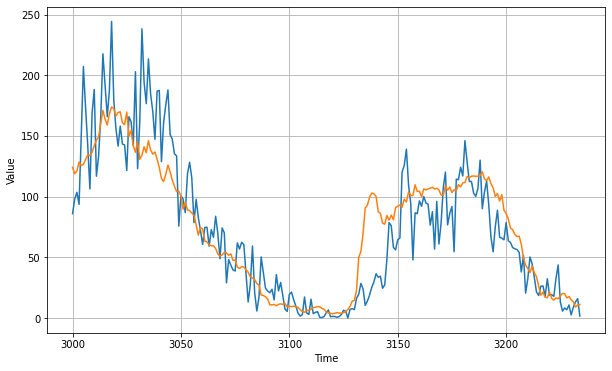

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

20.421642

In [17]:
series

array([ 96.7, 104.3, 116.7, ...,  13.2,  15.9,   1.6])